In [82]:
import backtrader as bt
import pandas as pd
from numpy import *
%matplotlib inline
import backtrader.analyzers as btanalyzers

df = pd.read_csv('BTCUSDTone.csv')
df.columns = ['open_time','open','high','low','close','volume','close_time']
df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
df = df.set_index('open_time')
# df = df.resample('15min').last()
df.head()

,open,high,low,close,volume,close_time
open_time,,,,,,
2019-10-01 00:01:00,8284.87,8286.05,8270.69,8277.74,37.510317,2019-10-01 00:01:59.999
2019-10-01 00:02:00,8276.55,8277.62,8265.51,8267.63,29.506321,2019-10-01 00:02:59.999
2019-10-01 00:03:00,8266.45,8268.50,8238.01,8245.50,104.431129,2019-10-01 00:03:59.999
2019-10-01 00:04:00,8242.72,8251.20,8240.01,8242.33,47.738354,2019-10-01 00:04:59.999
2019-10-01 00:05:00,8241.55,8249.79,8241.55,8248.00,14.731294,2019-10-01 00:05:59.999


In [83]:
feeds = bt.feeds.PandasDirectData(
    name='BTC', # 多股回测时用户区分数据对象
    timeframe = bt.TimeFrame.Minutes,
    dataname=df,
#     datetime=0,  # 日期行所在列
    dtformat=('%Y-%m-%d %H:%M:%S'), # 日期和时间格式
    tmformat=('%H:%M:%S'), # 时间格式
    open=1,  # 开盘价所在列
    high=2,  # 最高价所在列
    low=3,  # 最低价所在列
    close=4,  # 收盘价价所在列
    volume=5,  # 成交量所在列
    openinterest=-1,  # 无未平仓量列.(openinterest是期货交易使用的)
)

In [124]:
# 创建一个策略
pnl = pd.DataFrame()
value_lis = []
date_lis = []

sharpe_lis = []
class DualThrust(bt.Strategy):
    # 需要调优的参数
    params = (
        ('N', 7),
        ('K',0.3),
        ('stop_loss',3),
        ('stop_gain',100)
        )
    
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.close_p = self.datas[0].close
        self.high = self.datas[0].high
        self.low  = self.datas[0].low
        self.open = self.datas[0].open
        self.N = self.params.N
        self.K1 = self.params.K
        self.K2 = self.params.K
        self.stop_loss = self.params.stop_loss/100
        self.stop_gain = self.params.stop_gain/100
        
        self.high_lis = []
        self.low_lis = []
        self.close_p_lis = []
        self.single_day_high_lis = []
        self.single_day_low_lis = []
        
        self.day_counter = 0
        self.start_strategy = False
        
        self.BuyLine = None
        self.SellLine = None
        self.value_perday = []
        
    
    def prenext(self):
        pass
    
    def next(self):
        date = self.datas[0].datetime.datetime(0)
        day = str(date).split(' ')[0]
        time = str(date).split(' ')[1]
        size = self.getposition(data = self.datas[0]).size
        
        self.single_day_high_lis.append(self.high[0])
        self.single_day_low_lis.append(self.low[0])

        if time == '00:00:00':
            self.day_counter += 1
            self.open_ = self.open[0]
            self.close_p_lis.append(self.close_p[0])
            self.high_lis.append(max(self.single_day_high_lis))
            self.low_lis.append(min(self.single_day_low_lis))
            self.value_perday.append(self.broker.getvalue())
            
            self.single_day_high_lis = []
            self.single_day_low_lis = []
            
            if self.day_counter == self.N:
                # 计算各个指标
                HH = max(self.high_lis)
                LC = min(self.close_p_lis)
                HC = max(self.close_p_lis)
                LL = min(self.low_lis)
                Range = max(HH-LC,HC-LL)
                

                self.BuyLine = self.open_ + self.K1 * Range
                self.SellLine = self.open_ - self.K2 * Range
                # 去除第一个保持长度为N
                self.high_lis.remove(self.high_lis[0])
                self.low_lis.remove(self.low_lis[0])
                self.close_p_lis.remove(self.close_p_lis[0])
                self.start_strategy = True
                self.day_counter -= 1
                self.close()
                self.log('收盘平仓')
                self.no_buy = False
                self.no_sell = False

        if self.start_strategy:
            cross_upper = self.high[0] - self.BuyLine > 0
            cross_lower = self.low[0] - self.SellLine < 0
            
            if size != 0:
                unrealized_pnl = self.close_p[0]/self.position.price - 1    
                if (size > 0 and unrealized_pnl <= -self.stop_loss) or (size < 0 and unrealized_pnl >= self.stop_loss):
                    self.close()
                    self.log('止损平仓')
                    
                self.mh = max(self.close_p[0], self.close_p[-1], self.mh)
                self.ml = min(self.close_p[0], self.close_p[-1], self.ml)
                self.mv_loss_buy = self.close_p[0]/self.mh - 1
                self.mv_loss_sell = self.close_p[0]/self.ml - 1
                
                if (size > 0 and self.mv_loss_buy <= -0.01):
                    self.close()
                    self.log(f'止损平仓 {self.mh}')
                    self.BuyLine = self.mh
                    self.mh = 0

                if (size < 0 and self.mv_loss_sell >= 0.01):
                    self.close()
                    self.log(f'止损平仓 {self.ml}')
                    self.SellLine = self.ml
                    self.ml = 1000000

                
            if cross_upper and size <= 0:
                self.close()
                self.order_target_percent(target=0.9)
                self.log('-'*50+'买入开多'+'-'*50)
                self.log(self.getposition(data = self.datas[0]).size)
                self.mh = self.close_p[0]
                self.ml = self.close_p[0]
            if cross_lower and size >= 0:
                self.close()
                self.order_target_percent(target=-0.9)
                self.log('-'*50+'卖出做空'+'-'*50)
                self.log(self.getposition(data = self.datas[0]).size)
                self.ml = self.close_p[0]
                self.mh = self.close_p[0]

        # 获取当天value
        value = self.broker.getvalue()
        date_lis.append(date)
        value_lis.append(value)
        
    def stop(self):
        return_perday = [self.value_perday[x]/self.value_perday[x-1] - 1 for x in range(len(self.value_perday)) if x != 0]
        mean_v = mean(return_perday)
        std_v = std(return_perday)
        sharpe = (mean_v - 0.04/365)/std_v * 365 ** 0.5
        sharpe_lis.append(sharpe)

In [125]:
value_lis = []
date_lis = []

class CommInfoFractional(bt.CommissionInfo):
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)

cerebro = bt.Cerebro()
cerebro.broker.setcash(10000.0)
print('Starting Portfolio Value: %.5f' % cerebro.broker.getvalue())
cerebro.adddata(feeds)
cerebro.addstrategy(DualThrust)
cerebro.broker.setcommission(commission=0.0004)
commission = 0.001
comminfo = CommInfoFractional(commission=commission)
cerebro.broker.addcommissioninfo(comminfo)
cerebro.addanalyzer(btanalyzers.DrawDown, _name = "drawdown")
cerebro.addanalyzer(btanalyzers.Returns, _name = "returns",timeframe=bt.TimeFrame.Minutes)

thestrats = cerebro.run()
thestrat = thestrats[0]
print('Final Portfolio Value: %.5f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00000
2019-10-08, 收盘平仓
2019-10-09, 收盘平仓
2019-10-09, --------------------------------------------------买入开多--------------------------------------------------
2019-10-09, 0
2019-10-09, 止损平仓 8642.6
2019-10-09, --------------------------------------------------买入开多--------------------------------------------------
2019-10-09, 0.0
2019-10-09, 止损平仓 8662.43
2019-10-10, 收盘平仓
2019-10-11, 收盘平仓
2019-10-11, --------------------------------------------------卖出做空--------------------------------------------------
2019-10-11, 0.0
2019-10-11, 止损平仓 8279.96
2019-10-11, --------------------------------------------------卖出做空--------------------------------------------------
2019-10-11, 0.0
2019-10-12, 收盘平仓
2019-10-13, 收盘平仓
2019-10-14, 收盘平仓
2019-10-15, 收盘平仓
2019-10-15, --------------------------------------------------卖出做空--------------------------------------------------
2019-10-15, 0.0
2019-10-16, 收盘平仓
2019-10-16, --------------------------------------------------卖出做空------

2019-12-21, 收盘平仓
2019-12-22, 收盘平仓
2019-12-22, --------------------------------------------------买入开多--------------------------------------------------
2019-12-22, 0.0
2019-12-22, 止损平仓 7455.02
2019-12-22, --------------------------------------------------买入开多--------------------------------------------------
2019-12-22, 0.0
2019-12-23, 收盘平仓
2019-12-24, 收盘平仓
2019-12-25, 收盘平仓
2019-12-26, 收盘平仓
2019-12-26, --------------------------------------------------买入开多--------------------------------------------------
2019-12-26, 0.0
2019-12-26, 止损平仓 7425.02
2019-12-27, 收盘平仓
2019-12-28, 收盘平仓
2019-12-29, 收盘平仓
2019-12-29, --------------------------------------------------买入开多--------------------------------------------------
2019-12-29, 0.0
2019-12-29, 止损平仓 7524.0
2019-12-30, 收盘平仓
2019-12-30, --------------------------------------------------卖出做空--------------------------------------------------
2019-12-30, 0.0
2019-12-31, 收盘平仓
2019-12-31, --------------------------------------------------卖出做空--------

2020-02-17, --------------------------------------------------卖出做空--------------------------------------------------
2020-02-17, 0.0
2020-02-17, 止损平仓 9596.55
2020-02-17, --------------------------------------------------卖出做空--------------------------------------------------
2020-02-17, 0.0
2020-02-17, 止损平仓 9452.67
2020-02-18, 收盘平仓
2020-02-18, --------------------------------------------------买入开多--------------------------------------------------
2020-02-18, 0.0
2020-02-18, 止损平仓 10235.8
2020-02-19, 收盘平仓
2020-02-19, --------------------------------------------------卖出做空--------------------------------------------------
2020-02-19, 0.0
2020-02-19, 止损平仓 9869.95
2020-02-19, --------------------------------------------------卖出做空--------------------------------------------------
2020-02-19, 0.0
2020-02-19, 止损平仓 9416.9
2020-02-20, 收盘平仓
2020-02-21, 收盘平仓
2020-02-22, 收盘平仓
2020-02-23, 收盘平仓
2020-02-23, --------------------------------------------------买入开多-------------------------------------------

2020-04-08, 收盘平仓
2020-04-09, 收盘平仓
2020-04-09, --------------------------------------------------卖出做空--------------------------------------------------
2020-04-09, 0.0
2020-04-09, 止损平仓 7121.75
2020-04-10, 收盘平仓
2020-04-10, --------------------------------------------------卖出做空--------------------------------------------------
2020-04-10, 0.0
2020-04-10, 止损平仓 6920.38
2020-04-10, --------------------------------------------------卖出做空--------------------------------------------------
2020-04-10, 0.0
2020-04-10, 止损平仓 6881.82
2020-04-10, --------------------------------------------------卖出做空--------------------------------------------------
2020-04-10, 0.0
2020-04-10, 止损平仓 6870.08
2020-04-10, --------------------------------------------------卖出做空--------------------------------------------------
2020-04-10, 0.0
2020-04-10, 止损平仓 6828.29
2020-04-10, --------------------------------------------------卖出做空--------------------------------------------------
2020-04-10, 0.0
2020-04-10, 止损平仓 6757.15
2

2020-06-04, 收盘平仓
2020-06-05, 收盘平仓
2020-06-06, 收盘平仓
2020-06-07, 收盘平仓
2020-06-07, --------------------------------------------------卖出做空--------------------------------------------------
2020-06-07, 0.0
2020-06-07, 止损平仓 9426.07
2020-06-08, 收盘平仓
2020-06-09, 收盘平仓
2020-06-10, 收盘平仓
2020-06-10, --------------------------------------------------买入开多--------------------------------------------------
2020-06-10, 0.0
2020-06-10, 止损平仓 9973.3
2020-06-11, 收盘平仓
2020-06-11, --------------------------------------------------卖出做空--------------------------------------------------
2020-06-11, 0.0
2020-06-11, 止损平仓 9117.01
2020-06-12, 收盘平仓
2020-06-12, --------------------------------------------------买入开多--------------------------------------------------
2020-06-12, 0.0
2020-06-12, 止损平仓 9542.19
2020-06-13, 收盘平仓
2020-06-14, 收盘平仓
2020-06-15, 收盘平仓
2020-06-15, --------------------------------------------------卖出做空--------------------------------------------------
2020-06-15, 0.0
2020-06-15, 止损平仓 8934.0
2020-06-

2020-08-18, 收盘平仓
2020-08-18, --------------------------------------------------卖出做空--------------------------------------------------
2020-08-18, 0.0
2020-08-18, 止损平仓 11830.05
2020-08-19, 收盘平仓
2020-08-19, --------------------------------------------------卖出做空--------------------------------------------------
2020-08-19, 0.0
2020-08-19, 止损平仓 11624.68
2020-08-20, 收盘平仓
2020-08-21, 收盘平仓
2020-08-21, --------------------------------------------------卖出做空--------------------------------------------------
2020-08-21, 0.0
2020-08-21, 止损平仓 11647.18
2020-08-21, --------------------------------------------------卖出做空--------------------------------------------------
2020-08-21, 0.0
2020-08-21, 止损平仓 11620.95
2020-08-21, --------------------------------------------------卖出做空--------------------------------------------------
2020-08-21, 0.0
2020-08-22, 收盘平仓
2020-08-23, 收盘平仓
2020-08-24, 收盘平仓
2020-08-25, 收盘平仓
2020-08-25, --------------------------------------------------卖出做空-----------------------------

2020-10-20, --------------------------------------------------买入开多--------------------------------------------------
2020-10-20, 0.0
2020-10-20, 止损平仓 11918.0
2020-10-20, --------------------------------------------------买入开多--------------------------------------------------
2020-10-20, 0.0
2020-10-20, 止损平仓 12016.48
2020-10-21, 收盘平仓
2020-10-21, --------------------------------------------------买入开多--------------------------------------------------
2020-10-21, 0.0
2020-10-21, 止损平仓 12295.0
2020-10-21, --------------------------------------------------买入开多--------------------------------------------------
2020-10-21, 0.0
2020-10-21, 止损平仓 12813.03
2020-10-21, --------------------------------------------------买入开多--------------------------------------------------
2020-10-21, 0.0
2020-10-21, 止损平仓 12884.68
2020-10-21, --------------------------------------------------买入开多--------------------------------------------------
2020-10-21, 0.0
2020-10-21, 止损平仓 12972.46
2020-10-21, -------------------

In [126]:
sharpe_lis

[0.2039017736341989]

<IPython.core.display.Javascript object>


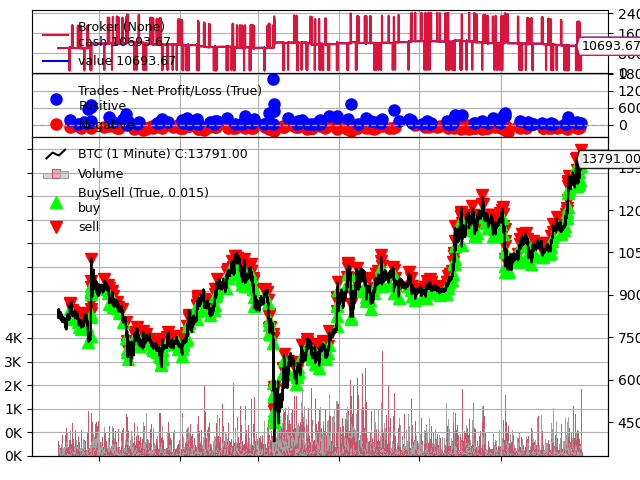

[[<Figure size 640x480 with 4 Axes>]]

In [127]:
cerebro.plot()

<IPython.core.display.Javascript object>


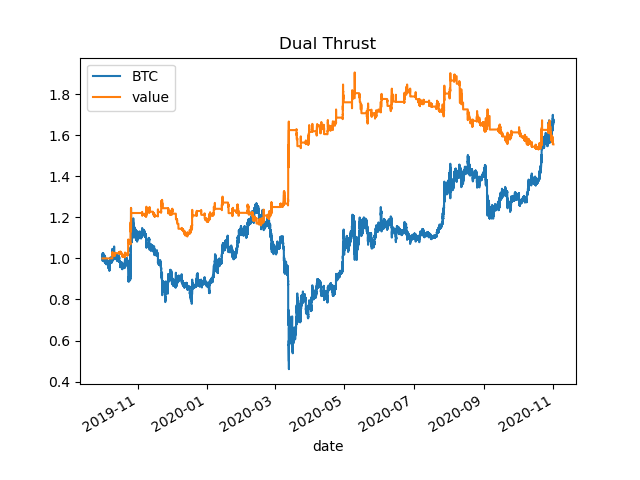

In [133]:
# 1
import numpy as np
pnl = pd.DataFrame()
pnl['date'] = date_lis
pnl['BTC'] = np.array(df['close']/df['close'][0])
pnl['value'] = np.array(value_lis)/value_lis[0]

pnl = pnl.set_index('date')
pnl.plot(title='Dual Thrust')

<IPython.core.display.Javascript object>


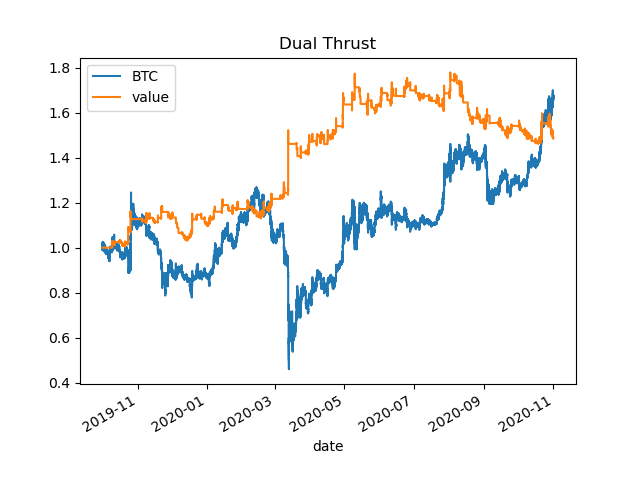

In [105]:
# 2
import numpy as np
pnl = pd.DataFrame()
pnl['date'] = date_lis
pnl['BTC'] = np.array(df['close']/df['close'][0])
pnl['value'] = np.array(value_lis)/value_lis[0]

pnl = pnl.set_index('date')
pnl.plot(title='Dual Thrust')

# 参数调优

In [60]:
class CommInfoFractional(bt.CommissionInfo):
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)

cerebro = bt.Cerebro()
cerebro.broker.setcash(10000.0)
print('Starting Portfolio Value: %.5f' % cerebro.broker.getvalue())
cerebro.adddata(feeds)
cerebro.broker.setcommission(commission=0.0004)

cerebro.optstrategy(
    strategy=DualThrust,
    N=[3, 7],
    K = [0.5],
    stop_loss = [0.2]
)

commission = 0.001
comminfo = CommInfoFractional(commission=commission)
cerebro.broker.addcommissioninfo(comminfo)
cerebro.addanalyzer(btanalyzers.DrawDown, _name = "drawdown")
cerebro.addanalyzer(btanalyzers.Returns, _name = "returns",timeframe=bt.TimeFrame.Minutes)
result = cerebro.run(maxcpus=1)
print('Final Portfolio Value: %.5f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00000
2021-11-12, 收盘平仓
2021-11-12, --------------------------------------------------卖出做空--------------------------------------------------
2021-11-12, 0
2021-11-12, 止损平仓
2021-11-13, 收盘平仓
2021-11-14, 收盘平仓
2021-11-15, 收盘平仓
2021-11-15, --------------------------------------------------卖出做空--------------------------------------------------
2021-11-15, 0.0
2021-11-16, 收盘平仓
2021-11-16, --------------------------------------------------卖出做空--------------------------------------------------
2021-11-16, 0.0
2021-11-16, 止损平仓
2021-11-16, --------------------------------------------------卖出做空--------------------------------------------------
2021-11-16, 0.0
2021-11-16, 止损平仓
2021-11-16, --------------------------------------------------卖出做空--------------------------------------------------
2021-11-16, 0.0
2021-11-17, 收盘平仓
2021-11-18, 收盘平仓
2021-11-18, --------------------------------------------------卖出做空--------------------------------------------------
2021-11-18, 

2022-01-01, 收盘平仓
2022-01-01, --------------------------------------------------买入开多--------------------------------------------------
2022-01-01, 0.0
2022-01-01, 止损平仓
2022-01-01, --------------------------------------------------买入开多--------------------------------------------------
2022-01-01, 0.0
2022-01-01, 止损平仓
2022-01-01, --------------------------------------------------买入开多--------------------------------------------------
2022-01-01, 0.0
2022-01-01, 止损平仓
2022-01-01, --------------------------------------------------买入开多--------------------------------------------------
2022-01-01, 0.0
2022-01-01, 止损平仓
2022-01-01, --------------------------------------------------买入开多--------------------------------------------------
2022-01-01, 0.0
2022-01-01, 止损平仓
2022-01-01, --------------------------------------------------买入开多--------------------------------------------------
2022-01-01, 0.0
2022-01-01, 止损平仓
2022-01-01, --------------------------------------------------买入开多-----------------

2022-02-07, 收盘平仓
2022-02-08, 收盘平仓
2022-02-08, --------------------------------------------------买入开多--------------------------------------------------
2022-02-08, 0.0
2022-02-08, 止损平仓
2022-02-09, 收盘平仓
2022-02-10, 收盘平仓
2022-02-10, --------------------------------------------------买入开多--------------------------------------------------
2022-02-10, 0.0
2022-02-10, 止损平仓
2022-02-11, 收盘平仓
2022-02-11, --------------------------------------------------卖出做空--------------------------------------------------
2022-02-11, 0.0
2022-02-11, 止损平仓
2022-02-11, --------------------------------------------------卖出做空--------------------------------------------------
2022-02-11, 0.0
2022-02-11, 止损平仓
2022-02-12, 收盘平仓
2022-02-13, 收盘平仓
2022-02-14, 收盘平仓
2022-02-15, 收盘平仓
2022-02-15, --------------------------------------------------买入开多--------------------------------------------------
2022-02-15, 0.0
2022-02-15, 止损平仓
2022-02-15, --------------------------------------------------买入开多-------------------------------

2022-03-19, 收盘平仓
2022-03-20, 收盘平仓
2022-03-20, --------------------------------------------------卖出做空--------------------------------------------------
2022-03-20, 0.0
2022-03-20, 止损平仓
2022-03-20, --------------------------------------------------卖出做空--------------------------------------------------
2022-03-20, 0.0
2022-03-20, 止损平仓
2022-03-20, --------------------------------------------------卖出做空--------------------------------------------------
2022-03-20, 0.0
2022-03-20, 止损平仓
2022-03-20, --------------------------------------------------卖出做空--------------------------------------------------
2022-03-20, 0.0
2022-03-21, 收盘平仓
2022-03-22, 收盘平仓
2022-03-22, --------------------------------------------------买入开多--------------------------------------------------
2022-03-22, 0.0
2022-03-23, 收盘平仓
2022-03-24, 收盘平仓
2022-03-24, --------------------------------------------------买入开多--------------------------------------------------
2022-03-24, 0.0
2022-03-24, 止损平仓
2022-03-25, 收盘平仓
2022-03-26, 收盘平

2022-05-09, 收盘平仓
2022-05-09, --------------------------------------------------卖出做空--------------------------------------------------
2022-05-09, 0.0
2022-05-09, 止损平仓
2022-05-09, --------------------------------------------------卖出做空--------------------------------------------------
2022-05-09, 0.0
2022-05-09, 止损平仓
2022-05-09, --------------------------------------------------卖出做空--------------------------------------------------
2022-05-09, 0.0
2022-05-10, 收盘平仓
2022-05-11, 收盘平仓
2022-05-11, --------------------------------------------------卖出做空--------------------------------------------------
2022-05-11, 0.0
2022-05-11, 止损平仓
2022-05-11, --------------------------------------------------卖出做空--------------------------------------------------
2022-05-11, 0.0
2022-05-11, 止损平仓
2022-05-12, 收盘平仓
2022-05-13, 收盘平仓
2022-05-13, --------------------------------------------------买入开多--------------------------------------------------
2022-05-13, 0.0
2022-05-13, 止损平仓
2022-05-14, 收盘平仓
2022-05-15, 收盘平

2022-06-23, 收盘平仓
2022-06-23, --------------------------------------------------买入开多--------------------------------------------------
2022-06-23, 0.0
2022-06-23, 止损平仓
2022-06-23, --------------------------------------------------买入开多--------------------------------------------------
2022-06-23, 0.0
2022-06-24, 收盘平仓
2022-06-25, 收盘平仓
2022-06-26, 收盘平仓
2022-06-27, 收盘平仓
2022-06-27, --------------------------------------------------买入开多--------------------------------------------------
2022-06-27, 0.0
2022-06-27, 止损平仓
2022-06-27, --------------------------------------------------卖出做空--------------------------------------------------
2022-06-27, 0.0
2022-06-27, 止损平仓
2022-06-28, 收盘平仓
2022-06-29, 收盘平仓
2022-06-30, 收盘平仓
2022-06-30, --------------------------------------------------卖出做空--------------------------------------------------
2022-06-30, 0.0
2022-06-30, 止损平仓
2022-07-01, 收盘平仓
2022-07-01, --------------------------------------------------买入开多------------------------------------------------

2022-08-17, 收盘平仓
2022-08-18, 收盘平仓
2022-08-19, 收盘平仓
2022-08-19, --------------------------------------------------卖出做空--------------------------------------------------
2022-08-19, 0.0
2022-08-19, 止损平仓
2022-08-19, --------------------------------------------------卖出做空--------------------------------------------------
2022-08-19, 0.0
2022-08-20, 收盘平仓
2022-08-21, 收盘平仓
2022-08-22, 收盘平仓
2022-08-23, 收盘平仓
2022-08-23, --------------------------------------------------卖出做空--------------------------------------------------
2022-08-23, 0.0
2022-08-23, 止损平仓
2022-08-24, 收盘平仓
2022-08-24, --------------------------------------------------卖出做空--------------------------------------------------
2022-08-24, 0.0
2022-08-24, 止损平仓
2022-08-24, --------------------------------------------------买入开多--------------------------------------------------
2022-08-24, 0.0
2022-08-24, 止损平仓
2022-08-25, 收盘平仓
2022-08-25, --------------------------------------------------买入开多------------------------------------------------

2022-09-29, 收盘平仓
2022-09-30, 收盘平仓
2022-10-01, 收盘平仓
2022-10-02, 收盘平仓
2022-10-03, 收盘平仓
2022-10-03, --------------------------------------------------买入开多--------------------------------------------------
2022-10-03, 0.0
2022-10-03, 止损平仓
2022-10-03, --------------------------------------------------买入开多--------------------------------------------------
2022-10-03, 0.0
2022-10-03, 止损平仓
2022-10-03, --------------------------------------------------买入开多--------------------------------------------------
2022-10-03, 0.0
2022-10-03, 止损平仓
2022-10-03, --------------------------------------------------买入开多--------------------------------------------------
2022-10-03, 0.0
2022-10-04, 收盘平仓
2022-10-04, --------------------------------------------------买入开多--------------------------------------------------
2022-10-04, 0.0
2022-10-04, 止损平仓
2022-10-04, --------------------------------------------------买入开多--------------------------------------------------
2022-10-04, 0.0
2022-10-04, 止损平仓
2022-10-04, ---

2021-11-16, 收盘平仓
2021-11-16, --------------------------------------------------卖出做空--------------------------------------------------
2021-11-16, 0
2021-11-16, 止损平仓
2021-11-16, --------------------------------------------------卖出做空--------------------------------------------------
2021-11-16, 0.0
2021-11-16, 止损平仓
2021-11-16, --------------------------------------------------卖出做空--------------------------------------------------
2021-11-16, 0.0
2021-11-16, 止损平仓
2021-11-16, --------------------------------------------------卖出做空--------------------------------------------------
2021-11-16, 0.0
2021-11-16, 止损平仓
2021-11-16, --------------------------------------------------卖出做空--------------------------------------------------
2021-11-16, 0.0
2021-11-16, 止损平仓
2021-11-16, --------------------------------------------------卖出做空--------------------------------------------------
2021-11-16, 0.0
2021-11-16, 止损平仓
2021-11-16, --------------------------------------------------卖出做空-------------------

2022-02-05, 收盘平仓
2022-02-06, 收盘平仓
2022-02-07, 收盘平仓
2022-02-08, 收盘平仓
2022-02-09, 收盘平仓
2022-02-10, 收盘平仓
2022-02-11, 收盘平仓
2022-02-12, 收盘平仓
2022-02-13, 收盘平仓
2022-02-14, 收盘平仓
2022-02-15, 收盘平仓
2022-02-15, --------------------------------------------------买入开多--------------------------------------------------
2022-02-15, 0.0
2022-02-15, 止损平仓
2022-02-15, --------------------------------------------------买入开多--------------------------------------------------
2022-02-15, 0.0
2022-02-15, 止损平仓
2022-02-15, --------------------------------------------------买入开多--------------------------------------------------
2022-02-15, 0.0
2022-02-15, 止损平仓
2022-02-15, --------------------------------------------------买入开多--------------------------------------------------
2022-02-15, 0.0
2022-02-16, 收盘平仓
2022-02-17, 收盘平仓
2022-02-17, --------------------------------------------------卖出做空--------------------------------------------------
2022-02-17, 0.0
2022-02-17, 止损平仓
2022-02-17, ----------------------------------

2022-05-19, 收盘平仓
2022-05-20, 收盘平仓
2022-05-20, --------------------------------------------------卖出做空--------------------------------------------------
2022-05-20, 0.0
2022-05-20, 止损平仓
2022-05-21, 收盘平仓
2022-05-22, 收盘平仓
2022-05-23, 收盘平仓
2022-05-23, --------------------------------------------------卖出做空--------------------------------------------------
2022-05-23, 0.0
2022-05-24, 收盘平仓
2022-05-25, 收盘平仓
2022-05-26, 收盘平仓
2022-05-26, --------------------------------------------------卖出做空--------------------------------------------------
2022-05-26, 0.0
2022-05-26, 止损平仓
2022-05-26, --------------------------------------------------卖出做空--------------------------------------------------
2022-05-26, 0.0
2022-05-26, 止损平仓
2022-05-26, --------------------------------------------------卖出做空--------------------------------------------------
2022-05-26, 0.0
2022-05-26, 止损平仓
2022-05-27, 收盘平仓
2022-05-28, 收盘平仓
2022-05-29, 收盘平仓
2022-05-30, 收盘平仓
2022-05-30, --------------------------------------------------买

2022-08-13, 收盘平仓
2022-08-14, 收盘平仓
2022-08-15, 收盘平仓
2022-08-16, 收盘平仓
2022-08-17, 收盘平仓
2022-08-18, 收盘平仓
2022-08-19, 收盘平仓
2022-08-19, --------------------------------------------------卖出做空--------------------------------------------------
2022-08-19, 0.0
2022-08-19, 止损平仓
2022-08-19, --------------------------------------------------卖出做空--------------------------------------------------
2022-08-19, 0.0
2022-08-20, 收盘平仓
2022-08-21, 收盘平仓
2022-08-22, 收盘平仓
2022-08-23, 收盘平仓
2022-08-24, 收盘平仓
2022-08-25, 收盘平仓
2022-08-26, 收盘平仓
2022-08-26, --------------------------------------------------卖出做空--------------------------------------------------
2022-08-26, 0.0
2022-08-26, 止损平仓
2022-08-26, --------------------------------------------------卖出做空--------------------------------------------------
2022-08-26, 0.0
2022-08-26, 止损平仓
2022-08-26, --------------------------------------------------卖出做空--------------------------------------------------
2022-08-26, 0.0
2022-08-27, 收盘平仓
2022-08-28, 收盘平仓
2022-08-29, 

In [62]:
par_list = [[x[0].params.N,
             x[0].params.K,
            x[0].analyzers.returns.get_analysis()['rtot'], 
            x[0].analyzers.drawdown.get_analysis()['max']['drawdown']/100,
                ] for x in result]

par_df = pd.DataFrame(par_list, columns = ['N', 'K', 'return', 'max_drawdown'])
par_df['sharpe'] = sharpe_lis
par_df

,N,K,return,max_drawdown,sharpe
0,3,0.5,-0.273350,0.382856,-0.843630
1,7,0.5,0.022323,0.191059,-0.016079
